# Celebrity Look a Like CNN DL Project

#### Mohamed Youssef - 211001821


## Index


-   [Including Necessary Libraries](#libs)
    <br>
-   [Other Utilites](#uti)
    <br>
-   [Loading & Cleaning the Data](#dataset)
    - [Reading Meta Data](#metadata)
    - [Creating Data Frame](#dataframe)
    - [Data Cleaning](#clean)
    <br>
-   [Visualization](#vis)
    -   [Univariate Exploration](#univis)
    -   [Bivariate Exploration](#bivis)
    <br>
-   [Preprocessing Data](#pre)
    -   [Getting Image Pixels](#pix)
    -   [Normalizing the Images](#norm)


## Including Necessary Librariess<a id='libs'></a>


In [1]:
# Disabling warnings
import warnings


def warn(*args, **kwargs):
    pass


warnings.warn = warn

In [2]:
# Python built-in libraries
from datetime import datetime, timedelta
import time
import os

# Other libraries
try:
    import chime
except:
    chime = None

# Libraries for preprocessing and visualizing the data
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from wordcloud import WordCloud, STOPWORDS

# OpenCV library for image processing
import cv2

# Tensorflow and Keras libraries for deep learning models
import tensorflow as tf

import keras
from keras.utils import img_to_array
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import (
    Dense,
    Activation,
    Dropout,
    Flatten,
    Input,
    Convolution2D,
    ZeroPadding2D,
    MaxPooling2D,
    Activation,
)
from keras.layers import Conv2D, AveragePooling2D
from keras.models import Model, Sequential
from keras import metrics
from keras.models import model_from_json


# Sklearn train test split function
from sklearn.model_selection import train_test_split

2023-11-24 15:24:01.014082: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-24 15:24:05.317239: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-11-24 15:24:05.319039: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

## Other Utilites<a id='uti'></a>


In [3]:
# Setting the path to the current directory
dir_path = os.getcwd()
print("Current directory is : " + dir_path)

Current directory is : /home/Momad/Projects/deep-learning-project-Momad-Y


In [4]:
# Configuring the GPU for training the model
gpus = tf.config.list_physical_devices("GPU")

if gpus:
    print("Num GPUs Available: ", gpus)

    try:
        tf.config.experimental.set_visible_devices(gpus[1], "GPU")
        tf.config.experimental.set_memory_growth(gpus[1], True)

    except:
        tf.config.experimental.set_visible_devices(gpus[0], "GPU")
        tf.config.experimental.set_memory_growth(gpus[0], True)
else:
    print("No GPU Available")

No GPU Available


2023-11-24 15:24:09.672638: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-11-24 15:24:09.674017: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-11-24 15:24:09.674065: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (instance-2023-11-23-1): /proc/driver/nvidia/version does not exist


In [5]:
# Initializing chime
if chime is not None:
    chime.theme("mario")
    chime.notify_exceptions()

In [6]:
# Check if the user wants to download the dataset
# download_dataset = input("Do you want to download the dataset? (y/n): ").lower().strip()
download_dataset = "n"

In [7]:
# Downloading the imdb_crop dataset from the link into the current/Data directory
if download_dataset == "y":
    !wget -P Data/imdb_crop https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/imdb_crop.tar

In [8]:
# Extracting the dataset from the tar file
if download_dataset == "y":
    !tar -xvf Data/imdb_crop/imdb_crop.tar -C Data/imdb_crop

## Loading & Cleaning the Data <a id='dataset'></a>


### Reading Meta Data <a id='metadata'></a>


In [9]:
# Loading the mat file containing the data
data_mat = scipy.io.loadmat(dir_path + "/Data/imdb_crop/imdb_crop/imdb.mat")

In [10]:
# Getting the total number of records in the data
records = data_mat["imdb"][0][0][0].shape[1]
print("Total no. of records: ", records)

Total no. of records:  460723


In [11]:
# Getting the column names of the data
features = data_mat["imdb"][0][0].dtype
features = list(features.names)
print("Total no. of features: ", len(features))

Total no. of features:  10


In [12]:
# Rename the columns of the data
print("Current Features Names:\n", features)
features[0] = "Date of Birth"
features[1] = "Photo Taken Date"
features[2] = "Full Img Path"
features[3] = "Gender"
features[4] = "Celebrity Name"
features[5] = "Face Location"
features[6] = "Face Score"
features[7] = "Second Face Score"
features[8] = "Celeb Names"
features[9] = "Celeb ID"
print("New Features Names:\n", features)

Current Features Names:
 ['dob', 'photo_taken', 'full_path', 'gender', 'name', 'face_location', 'face_score', 'second_face_score', 'celeb_names', 'celeb_id']
New Features Names:
 ['Date of Birth', 'Photo Taken Date', 'Full Img Path', 'Gender', 'Celebrity Name', 'Face Location', 'Face Score', 'Second Face Score', 'Celeb Names', 'Celeb ID']


### Creating Data Frame <a id='dataframe'></a>


In [13]:
# Creating a dataframe to store the data
data_df = pd.DataFrame(index=(range(0, records)), columns=features)

In [14]:
# Extracting the data from the mat file and storing it in a dataframe
for i in data_mat:
    if i == "imdb":
        current_array = data_mat[i][0][0]
        for j in range(len(current_array)):
            data_df[features[j]] = pd.DataFrame(current_array[j][0])

In [15]:
# Displaying 5 random rows of the data
data_df.sample(5)

,Date of Birth,Photo Taken Date,Full Img Path,Gender,Celebrity Name,Face Location,Face Score,Second Face Score,Celeb Names,Celeb ID
100227,718319,1995,[91/nm0001191_rm2503577088_1966-9-9_1995.jpg],1.0,[Adam Sandler],"[[1082.9888805051548, 391.1867169818558, 1275....",2.907359,2.778446,NaN,149
107988,715603,1998,[83/nm0001383_rm3858733056_1959-4-3_1998.jpg],1.0,[David Hyde Pierce],"[[153.0721631493166, 80.14399816486082, 212.15...",3.134033,3.084813,NaN,4677
138889,720717,2009,[95/nm0004395_rm1251340800_1973-4-3_2009.jpg],1.0,[Adam Scott],"[[209, 81, 352, 224]]",3.150141,2.899320,NaN,153
46361,706087,1984,[23/nm0000323_rm3892610048_1933-3-14_1984.jpg],1.0,[Michael Caine],"[[202.53671757629587, 323.44494812207336, 564....",2.474157,NaN,NaN,13498
132323,721587,2008,[60/nm0001860_rm892573184_1975-8-21_2008.jpg],0.0,[Alicia Witt],"[[75.10355536407178, 93.71244420508972, 241.91...",5.211692,NaN,NaN,622


In [16]:
# Describing the data
data_df.describe()

,Date of Birth,Photo Taken Date,Gender,Face Score,Second Face Score,Celeb ID
count,460723.000000,460723.000000,452261.000000,4.607230e+05,213797.000000,460723.000000
mean,718987.731774,2005.461555,0.581996,-inf,2.452904,10116.802404
std,13253.963535,9.054475,0.493231,NaN,1.064432,5742.153266
min,47.000000,1961.000000,0.000000,-inf,0.730926,1.000000
25%,716370.000000,2004.000000,0.000000,1.757891e+00,1.583692,5294.000000
50%,719935.000000,2008.000000,1.000000,2.980097e+00,2.355163,10066.000000
75%,723073.000000,2011.000000,1.000000,4.006376e+00,3.228071,14922.000000
max,734963.000000,2015.000000,1.000000,7.381689e+00,6.395435,20284.000000


In [17]:
# Checking for null values in the data
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460723 entries, 0 to 460722
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Date of Birth      460723 non-null  int32  
 1   Photo Taken Date   460723 non-null  uint16 
 2   Full Img Path      460723 non-null  object 
 3   Gender             452261 non-null  float64
 4   Celebrity Name     460723 non-null  object 
 5   Face Location      460723 non-null  object 
 6   Face Score         460723 non-null  float64
 7   Second Face Score  213797 non-null  float64
 8   Celeb Names        20284 non-null   object 
 9   Celeb ID           460723 non-null  uint16 
dtypes: float64(3), int32(1), object(4), uint16(2)
memory usage: 28.1+ MB


### Data Cleaning <a id='clean'></a>


In [18]:
# Removing pictures with no face detected
data_df = data_df[data_df["Face Score"] != -np.inf]
print("Total no. of records with no face detected removed:", records - len(data_df))
records = len(data_df)  # Updating the total number of records
print("Total no. of records after removing records with no face detected:", records)

Total no. of records with no face detected removed: 62302
Total no. of records after removing records with no face detected: 398421


In [19]:
# Removing pictures with more than one face detected
data_df = data_df[data_df["Second Face Score"].isna()]
print(
    "Total no. of records with more than one face detected removed:",
    records - len(data_df),
)
records = len(data_df)  # Updating the total number of records
print("Total no. of records after removing pictures with more the one face:", records)

Total no. of records with more than one face detected removed: 213797
Total no. of records after removing pictures with more the one face: 184624


In [20]:
# Removing pictures with low face scores
data_df = data_df[data_df["Face Score"] >= 3]
print(
    "Total no. of records with low face scores removed:",
    records - len(data_df),
)
records = len(data_df)  # Updating the total number of records
print("Total no. of records after removing pictures with low face scores:", records)

Total no. of records with low face scores removed: 89390
Total no. of records after removing pictures with low face scores: 95234


In [21]:
# Creating a function to extract first index of an array
def extract_data(arr):
    return arr[0]

In [22]:
# Extracting the data from the array columns of the dataframe
data_df["Celebrity Name"] = data_df["Celebrity Name"].apply(extract_data)
data_df["Full Img Path"] = data_df["Full Img Path"].apply(extract_data)

In [23]:
# Dropping the unnecessary columns from the dataframe
data_df.drop(
    ["Celeb ID", "Celeb Names", "Face Score", "Second Face Score", "Face Location"],
    axis=1,
    inplace=True,
)

In [24]:
# Creating a function to convert the matlab serial date number to python date time object
def convert_date(date_number):
    str_date = str(date_number)
    # If the length of the string is 4, then the date is in the format YYYY
    if len(str_date) == 4:
        full_date = datetime.strptime(str_date, "%Y")
        return full_date.strftime("%Y")
    else:
        try:
            date_time = (
                datetime.fromordinal(int(date_number))
                + timedelta(days=date_number % 1)
                - timedelta(days=366)
            )
            return date_time
        except OverflowError:
            return pd.NaT

In [25]:
# Converting the matlab serial date number to python date time object
data_df["Date of Birth"] = data_df["Date of Birth"].apply(convert_date)

In [26]:
# Converting the Photo Taken Date to python year date time object
data_df["Photo Taken Date"] = data_df["Photo Taken Date"].apply(convert_date)

In [27]:
# Creating a function to calculate the age of the celebrity
def calculate_age_at_photo(born, photo_taken):
    photo_taken = datetime.strptime(photo_taken, "%Y")
    try:
        return (
            photo_taken.year
            - born.year
            - ((photo_taken.month, photo_taken.day) < (born.month, born.day))
        )
    except AttributeError:
        return np.nan

In [28]:
# Calculating the age of the celebrity
data_df["Age at Photo"] = data_df.apply(
    lambda x: calculate_age_at_photo(x["Date of Birth"], x["Photo Taken Date"]), axis=1
)
# Changing the datatype of the age column to integer
data_df["Age at Photo"] = data_df["Age at Photo"].astype("Int64")

In [29]:
# Creating a function to calculate the current age of the celebrity
def calculate_age(born):
    today = datetime.today()
    try:
        return (
            today.year - born.year - ((today.month, today.day) < (born.month, born.day))
        )
    except AttributeError:
        return np.nan

In [30]:
# Calculating the current age of the celebrity
data_df["Current Age"] = data_df["Date of Birth"].apply(calculate_age)
# Changing the datatype of the age column to integer
data_df["Current Age"] = data_df["Current Age"].astype("Int64")

In [31]:
# Dropping the Date of Birth and Photo Taken Date columns
data_df.drop(["Date of Birth", "Photo Taken Date"], axis=1, inplace=True)

In [32]:
# Dropping any rows with null values
data_df.dropna(inplace=True)
print("Total no. of records with null values removed:", records - len(data_df))
records = len(data_df)  # Updating the total number of records
print("Total no. of records after removing null values:", len(data_df))

Total no. of records with null values removed: 1734
Total no. of records after removing null values: 93500


In [33]:
# Removing the records with age at photo less than 0
data_df = data_df[data_df["Age at Photo"] >= 0]

In [34]:
# Changing the datatype of the gender column to integer
data_df["Gender"] = data_df["Gender"].astype(int)

In [35]:
# Reordering the columns of the dataframe
data_df = data_df.reindex(
    columns=["Celebrity Name", "Gender", "Current Age", "Age at Photo", "Full Img Path"]
)

In [36]:
# Resetting the index of the dataframe
data_df.reset_index(drop=True, inplace=True)

In [37]:
# Displaying 5 random rows of the data
data_df.sample(5)

,Celebrity Name,Gender,Current Age,Age at Photo,Full Img Path
37154,Owen Wilson,1,55,39,62/nm0005562_rm514034176_1968-11-18_2008.jpg
82514,Caterina Scorsone,0,42,28,41/nm0778741_rm1151569664_1981-10-16_2010.jpg
80712,Rachel Bilson,0,42,22,75/nm1377375_rm4275346176_1981-8-25_2004.jpg
62976,Clea DuVall,0,46,34,12/nm0245112_rm3733630464_1977-9-25_2012.jpg
75929,Keira Knightley,0,38,20,36/nm0461136_rm2118097408_1985-3-26_2006.jpg


In [38]:
# Describing the data
data_df.describe()

,Gender,Current Age,Age at Photo
count,93417.000000,93417.0,93417.0
mean,0.486164,52.594592,35.073841
std,0.499811,14.150854,12.710267
min,0.000000,16.0,0.0
25%,0.000000,43.0,26.0
50%,0.000000,51.0,33.0
75%,1.000000,60.0,42.0
max,1.000000,147.0,133.0


In [39]:
# Checking for null values in the data
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93417 entries, 0 to 93416
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Celebrity Name  93417 non-null  object
 1   Gender          93417 non-null  int64 
 2   Current Age     93417 non-null  Int64 
 3   Age at Photo    93417 non-null  Int64 
 4   Full Img Path   93417 non-null  object
dtypes: Int64(2), int64(1), object(2)
memory usage: 3.7+ MB


In [40]:
# Displaying the number of unique celebrities in the data
print("Total no. of unique celebrities:", len(data_df["Celebrity Name"].unique()))

Total no. of unique celebrities: 11417


## Visualization <a id="vis"></a>


### Univariate Exploration <a id="univis"></a>


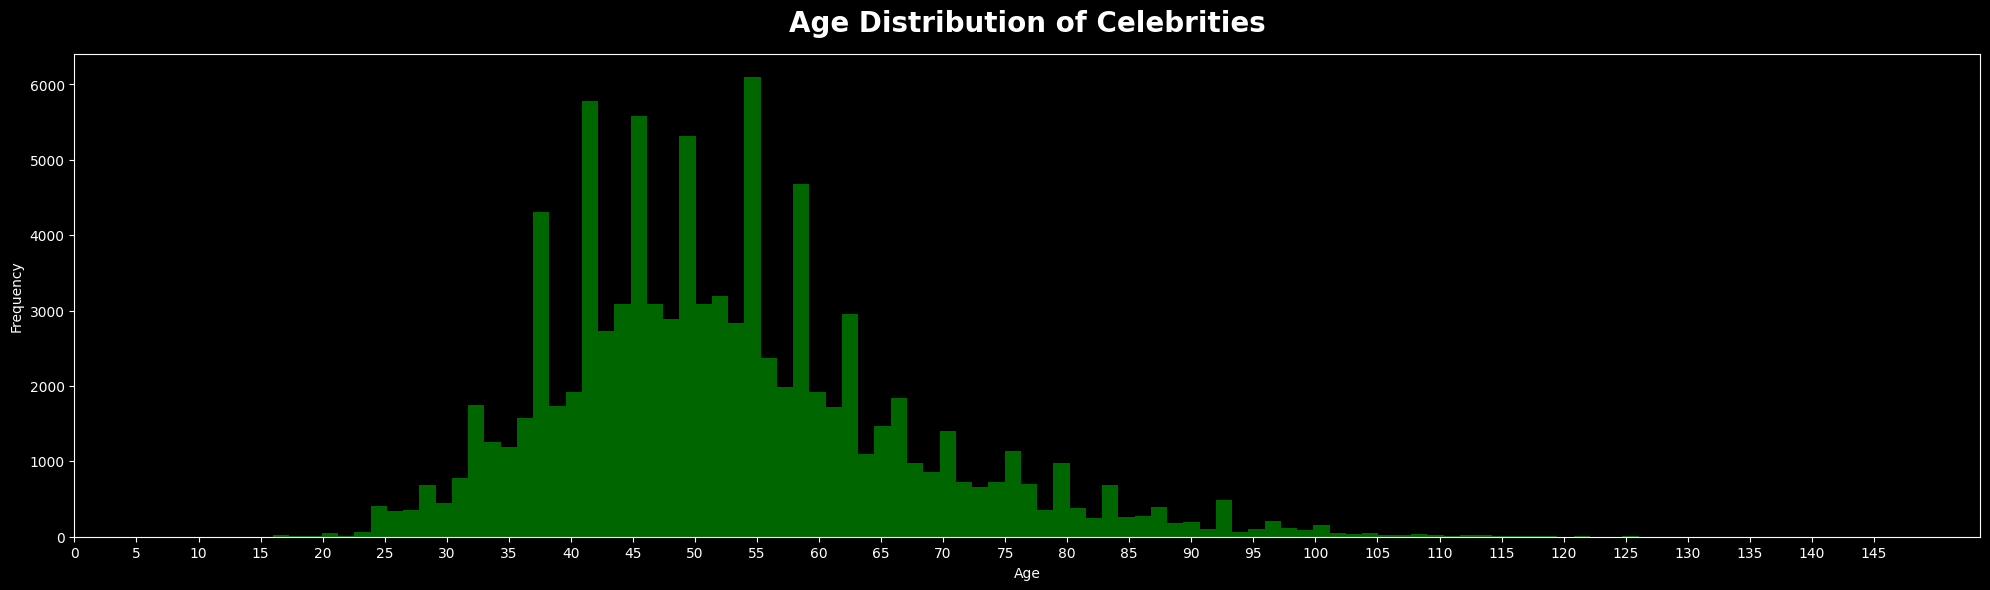

In [41]:
# Plotting the distribution of the age of the celebrities
plt.figure(figsize=(20, 6))
plt.hist(data_df["Current Age"], bins=100, color="green", alpha=0.8)
max_age = data_df["Current Age"].max()
plt.xticks(range(0, max_age, 5))
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.title("Age Distribution of Celebrities", fontsize=20, fontweight="bold", y=1.03)
plt.tight_layout()
plt.show()

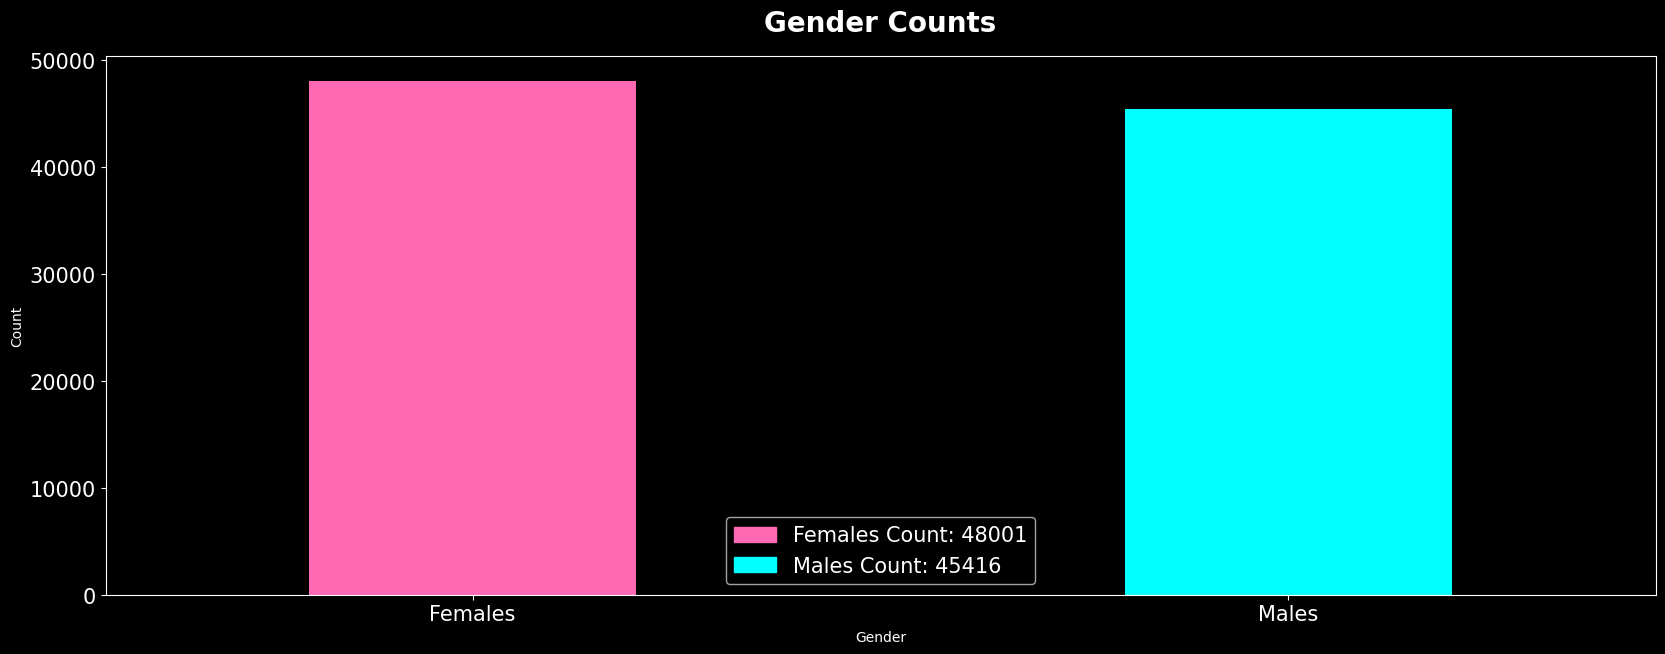

In [42]:
# Plotting the distribution genders in the celebrities dataset
gender_counts = data_df["Gender"].value_counts()
gender_counts.rename({0: "Females", 1: "Males"}, inplace=True)

plt.figure(figsize=(20, 7))
gender_counts.plot(kind="bar", color=["hotpink", "aqua"], rot=0, width=0.4)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.xlabel("Gender")
plt.ylabel("Count")

plt.title("Gender Counts", fontsize=20, fontweight="bold", y=1.03)

females_patch = mpatches.Patch(
    color="hotpink", label=f"Females Count: {gender_counts[0]}"
)
males_patch = mpatches.Patch(color="aqua", label=f"Males Count: {gender_counts[1]}")
plt.legend(handles=[females_patch, males_patch], fontsize=15)

plt.show()

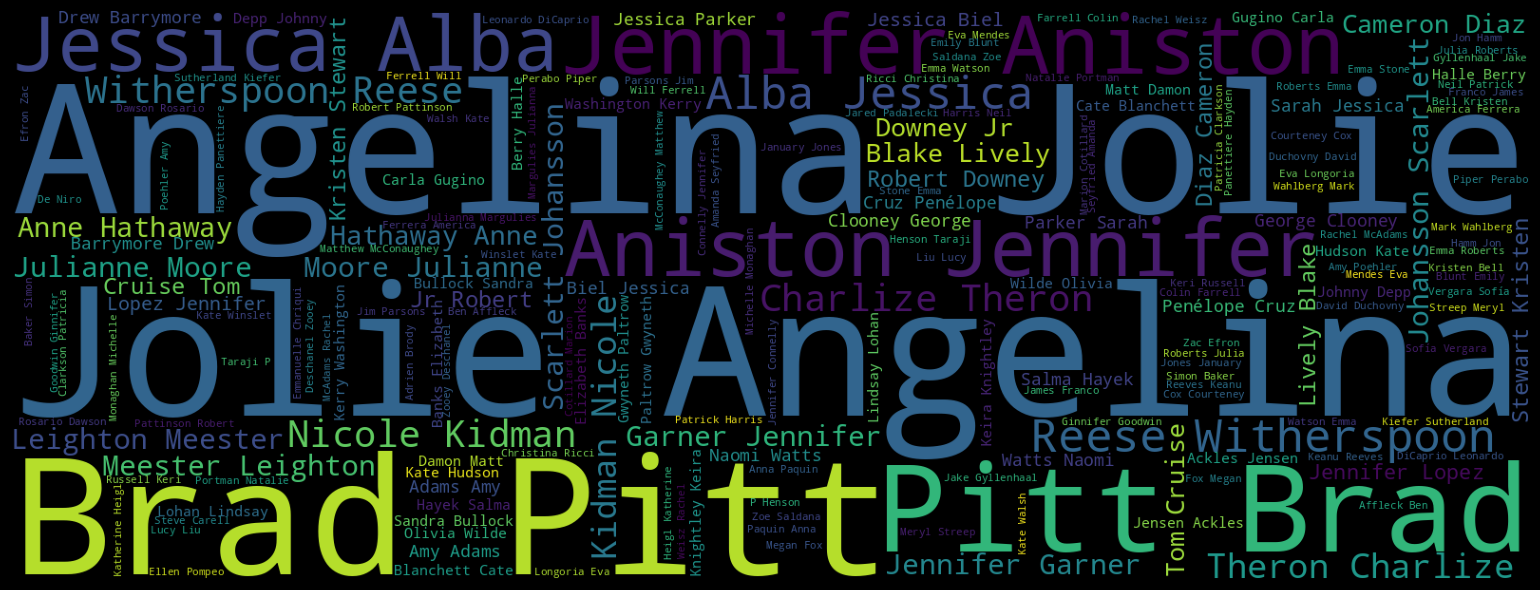

In [43]:
# Showing a word cloud of the celebrity names
# Add tictoc ?
celebs = ""
stopwords = set(STOPWORDS)

# Iterate through the names
for celeb in data_df["Celebrity Name"]:
    celeb = str(celeb)

    # Split the name keywords
    keywords = celeb.split()

    celebs += " ".join(keywords) + " "

# Create and generate a word cloud image
directors_wordcloud = WordCloud(
    width=1600,
    height=600,
    background_color="black",
    stopwords=stopwords,
    min_font_size=10,
).generate(celebs)

# Plotting the WordCloud image
plt.figure(figsize=(18, 6))
plt.imshow(directors_wordcloud)
plt.axis("off")
plt.tight_layout()
plt.show()

### Bivariate Exploration <a id="bivis"></a>


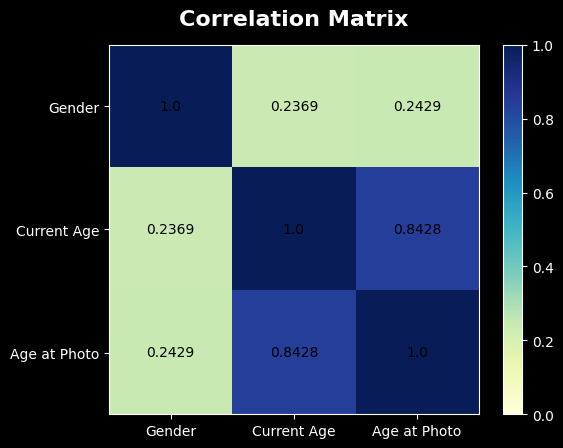

In [44]:
# Plotting the correlation matrix of the data using a heatmap
corr = data_df[["Gender", "Current Age", "Age at Photo"]].corr()
plt.imshow(corr, cmap="YlGnBu", interpolation="nearest", vmin=0, vmax=1)
plt.colorbar()

for i in range(3):
    for j in range(3):
        plt.annotate(
            str(round(corr.values[i][j], 4)),
            xy=(j, i),
            ha="center",
            va="center",
            color="black",
        )

plt.title("Correlation Matrix", fontsize=16, fontweight="bold", y=1.03)

plt.xticks(range(len(corr.columns)), corr.columns)
plt.yticks(range(len(corr.columns)), corr.columns)

plt.show()

### Multivariate Exploration


## Preprocessing Data <a id='pre'></a>


In [45]:
# Checking if the user wants to skip data preprocessing
# skip_preprocessing = (
#     input("Do you want to skip data preprocessing? (y/n): ").lower().strip()
# )
skip_preprocessing = "n"

### Getting Images Pixels <a id='pix'></a>


In [46]:
# Creating a function to load the image pixels from the path
if skip_preprocessing == "n":

    def load_imgs(path):
        return cv2.imread(dir_path + "/Data/imdb_crop/imdb_crop/" + path)

In [47]:
# Loading the image pixels from the path
if skip_preprocessing == "n":
    toc = time.time()
    data_df["Image Pixels"] = data_df["Full Img Path"].apply(load_imgs)
    tic = time.time()

    img_pixels_time = str(timedelta(seconds=tic - toc))
    print(
        "Time taken to load the images",
        img_pixels_time[0:1],
        "hours",
        img_pixels_time[2:4],
        "minutes and",
        img_pixels_time[5:10],
        "seconds",
    )

In [ ]:
# Dropping the Full Img Path column
if skip_preprocessing == "n":
    data_df.drop("Full Img Path", axis=1, inplace=True)

In [ ]:
# Displaying 5 random rows of the data
data_df.sample(5)

,Celebrity Name,Gender,Current Age,Age at Photo,Image Pixels
52726,Dwayne Johnson,1,51,35,"[[[174, 169, 166], [174, 169, 166], [174, 169,..."
37269,Serena Scott Thomas,0,62,43,"[[[3, 5, 6], [3, 5, 6], [3, 5, 6], [3, 5, 6], ..."
153,Elvis Presley,1,88,45,"[[[9, 9, 9], [9, 9, 9], [9, 9, 9], [9, 9, 9], ..."
73449,Kathryn Hahn,0,49,40,"[[[75, 106, 129], [78, 109, 132], [82, 113, 13..."
43687,Leighton Meester,0,37,20,"[[[39, 62, 78], [30, 56, 72], [48, 78, 95], [6..."


In [ ]:
# Displaying the datatype of the image pixels column
print("Datatype of the image pixels column:", type(data_df["Image Pixels"][0]))

Datatype of the image pixels column: <class 'numpy.ndarray'>


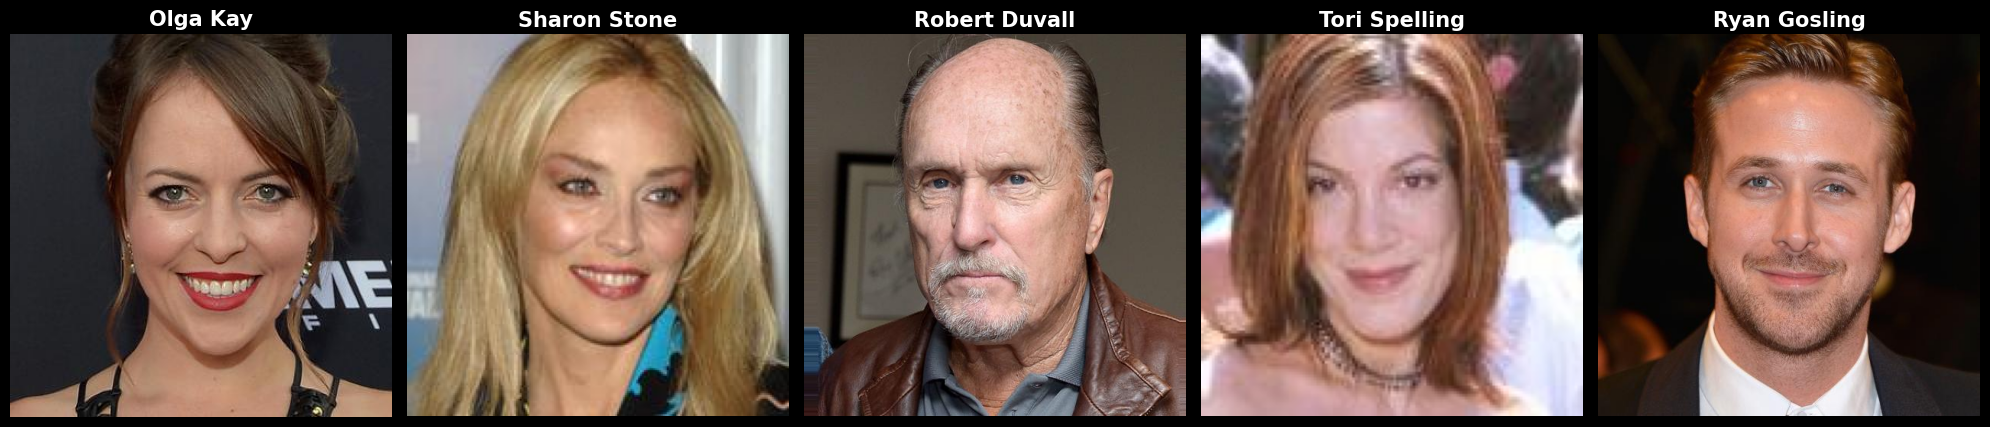

In [ ]:
# Displaying the 5 random images of celebrities
plt.figure(figsize=(20, 6))
for i in range(5):
    random_index = np.random.randint(0, len(data_df))
    img_pixels = data_df["Image Pixels"][random_index]  # Selecting a random image
    img_pixels = cv2.cvtColor(img_pixels, cv2.COLOR_BGR2RGB)  # Apply color conversion
    plt.subplot(1, 5, i + 1)
    plt.imshow(img_pixels)
    plt.title(data_df["Celebrity Name"][random_index], fontsize=15, fontweight="bold")
    plt.axis("off")
plt.tight_layout()
plt.show()

### Normalizing the Images <a id='norm'></a>


In [ ]:
# Creating a function to resize and normalize the image pixels
if skip_preprocessing == "n":

    def resize_normalize_img(img):
        img_pixels = img

        # Resizing the image pixels to 224 x 224
        img_pixels = cv2.resize(img_pixels, (224, 224))

        # Converting the image pixels to float32
        img_pixels = img_pixels.astype("float32")

        # Normalizing the image pixels to the range [-1, 1]
        img_pixels /= 127.5
        img_pixels -= 1

        return img_pixels

In [ ]:
# Resizing and normalizing the image pixels
if skip_preprocessing == "n":
    toc = time.time()
    data_df["Normalized Image Pixels"] = data_df["Image Pixels"].apply(
        resize_normalize_img
    )
    tic = time.time()

    img_norm_time = str(timedelta(seconds=tic - toc))

    print(
        "Time taken to load the images",
        img_norm_time[0:1],
        "hours",
        img_norm_time[2:4],
        "minutes and",
        img_norm_time[5:10],
        "seconds",
    )

In [ ]:
# Displaying 5 random rows of the data
data_df.sample(5)

In [ ]:
# Displaying the 5 random normalized images of celebrities
plt.figure(figsize=(20, 6))
for i in range(5):
    random_index = np.random.randint(0, len(data_df))
    img_pixels = data_df["Normalized Image Pixels"][random_index]
    plt.subplot(1, 5, i + 1)
    plt.imshow(cv2.cvtColor(img_pixels, cv2.COLOR_BGR2RGB))
    plt.title(data_df["Celebrity Name"][random_index], fontsize=15, fontweight="bold")
    plt.axis("off")
plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

In [ ]:
# Showing the dimensions of the image pixels
print("Dimensions of the image pixels:", data_df["Image Pixels"][0].shape)

In [ ]:
# Save the dataframe to a csv file
data_df.to_csv(dir_path + "/Data/norm_data_df.csv", index=False)

In [ ]:
# Save the dataframe to a pickle file
data_df.to_pickle(dir_path + "/Data/norm_data_df.pkl")

## Neural Network Construction


### Building the Network
